<img src="https://afs-services.com/wp-content/uploads/2025/09/pypricing_banner.png" alt="RV Banner" style="width: 100%; height: auto; display: block;">

### Importing

In [1]:
# general packages

import sys, os, json

import pandas as pd
import numpy as np
import plotly.graph_objs as go
import pandas as pd

# our library
pypricing_directory = os.path.expanduser("..")
sys.path.insert(1, pypricing_directory)
from afslibrary import *

import db_tools

# beautiful_data = db_tools.BeautifulDataAFSStyle()
beautiful_data = db_tools.BeautifulDataAFSStyleXL()  # Uses xls instead of csv

d = DataFactory(beautiful_data)
cds_curve_data = beautiful_data.load_curve(
    "EDPFIN SR", start_date="20220901", end_date="20221031"
)
# discount_curves = d.import_discount_curves("ESTR", start_date="20200101", end_date="20221231")
calendars = d.import_calendar("Act360", "Act365")

import db_tools

db = db_tools.BeautifulDataAFSStyleXL()

# CRDC (Constant Rate Discount Curve)

In [2]:
constant_discount = CRDC(r=1, calendar=calendars["Act360"])

In [3]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act360"],
)

array([0.36280532, 0.36179893])

In [4]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act365"],
)

array([0.36787944, 0.36687293])

If no calendar is introduced, it uses the one of the discount curve. **This is a general feature of all discount curves.**

In [5]:
constant_discount.get_value(dates="20220101", future_dates=["20230101", "20230102"])

array([0.36280532, 0.36179893])

Tenor can be used instead of future_dates, but future_dates has preference in case of "conflict". **This is a general feature of all discount curves.**

In [6]:
constant_discount.get_value(
    dates="20220101", tenors=np.array([1, 1.01]), calendar=calendars["Act360"]
)

array([0.36787944, 0.36421898])

In [7]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    tenors=np.array([1, 1.01]),
    calendar=calendars["Act360"],
)

array([0.36280532, 0.36179893])

# LCExpCurve

In [8]:
edp_curve = LCExpCurve(calendar=calendars["Act360"])

In [9]:
ticker = "EDPFIN SR"
discount_curve = "ESTR"
specs = cds_curve_data[ticker]["Specs"]
cds_spreads = cds_curve_data[ticker]["Data"]
cds_spreads = cds_spreads.rename(
    columns={column: specs.loc[column, "Tenor"] for column in cds_spreads.columns}
)
cds_spreads

,1.1,2.2,3.3,4.4,5.5,6.6,7.7,8.8,9.9,11.0
2022-09-15,0.005911,0.007230,0.009022,0.011178,0.013282,0.014903,0.015997,0.017144,0.018006,0.018676
2022-09-30,0.007610,0.009187,0.011194,0.013492,0.015493,0.016969,0.018025,0.019124,0.019974,0.020650
2022-10-14,0.007769,0.009363,0.011395,0.013719,0.015741,0.017225,0.018282,0.019380,0.020228,0.020899
2022-10-31,0.006650,0.007998,0.009727,0.011706,0.013412,0.014746,0.015742,0.016798,0.017634,0.018314


In [10]:
edp_curve.fit(cds_spreads)
edp_curve.params[0]

,1.1,2.2,3.3,4.4,5.5,6.6,7.7,8.8,9.9,11.0
2022-09-15,0.005911,0.007230,0.009022,0.011178,0.013282,0.014903,0.015997,0.017144,0.018006,0.018676
2022-09-30,0.007610,0.009187,0.011194,0.013492,0.015493,0.016969,0.018025,0.019124,0.019974,0.020650
2022-10-14,0.007769,0.009363,0.011395,0.013719,0.015741,0.017225,0.018282,0.019380,0.020228,0.020899
2022-10-31,0.006650,0.007998,0.009727,0.011706,0.013412,0.014746,0.015742,0.016798,0.017634,0.018314


In [11]:
edp_curve.get_value(
    dates="20221014",
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act360"],
)

array([1.00170638, 1.001728  ])

In [12]:
edp_curve.get_value(
    dates=["20220915", "20221014"],
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act360"],
)

array([1.00177483, 1.001728  ])

In [13]:
edp_curve.get_value(
    dates=["20221014", "20221031"],
    future_dates=["20230101"],
    calendar=calendars["Act360"],
)

array([1.00170638, 1.00114594])

# Cubic Spline

In [14]:
# Assume we have a CRDC object
crdc1 = CRDC(r=0.01, calendar=None)
crdc2 = CRDC(r=0.02, calendar=None)

# Create a pandas DataFrame with data generated from CRDC
dates = pd.date_range("2023-02-02", periods=2)
crdc = {}
crdc[dates[0]] = crdc1
crdc[dates[1]] = crdc2

tenors = np.linspace(0, 30, 5)  # Assuming tenors range from 0 to 30
random = 0.15 * np.random.rand(len(tenors))  # We add a random perturbation
data = pd.DataFrame(
    {
        date: np.full(
            len(tenors), crdc[date].get_value(dates=date, tenors=tenors) + random
        )
        for date in dates
    },
    index=tenors,
).transpose()
data

,0.0,7.5,15.0,22.5,30.0
2023-02-02,1.090381,0.953849,0.969919,0.826154,0.809187
2023-02-03,1.090381,0.886813,0.850029,0.665266,0.617180


Perturbation of yields for the whole curve

In [15]:
calendar = calendars["Act360"]
# Create an instance of YieldCurve
curve = YieldCurve(calendar)

# Fit the data
curve.fit(data)

# Plot the fitted data

# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30)

# Figure for cubic spline perturbations
fig_per = go.Figure()


for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    curve.p = p
    curve_values = curve.get_value(dates="2023-02-02", tenors=tenors)
    curve_values

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    y_data = curve_values
    x_original = data.columns.values
    y_original = data.loc["2023-02-02"].values
    fig.add_trace(go.Scatter(x=x_data, y=y_data, name="Fitted Data"))
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data, name=f"Spline for p={p}"))
    fig.add_trace(go.Scatter(x=x_original, y=y_original, name="Original Data"))

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.show()
fig_per.show()

Now, the perturbation of the yield only happens for a given date

The perturbation at a given point propagates through the whole tenor structure, which is problematic, see Andersen and Piterbarg, Section 6.4 (Figure 6.7).

In [16]:
data.loc["2023-02-02"][22.5] * (
    1 - np.exp(-0.0005 * 22.5)
)  # Magnitude of the perturbation at tenor=22.5

0.009242152724797547

Some checks

In [17]:
curve.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act365"],
)

array([1.08681696, 1.08668612])

If no calendar is introduced, it uses the one of the discount curve. **This is a general feature of all discount curves.**

In [18]:
curve.get_value(dates="2023-02-02", future_dates=["20230301", "20230302"])

array([1.08676788, 1.08663526])

As the calendar is ``Act360`` this is equivalent to:

In [19]:
curve.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act360"],
)

array([1.08676788, 1.08663526])

Tenor can be used instead of future_dates, but future_dates has preference in case of "conflict". **This is a general feature of all discount curves.**

In [20]:
curve.get_value(
    dates="2023-02-02", tenors=np.array([1, 1.01]), calendar=calendars["Act360"]
)

array([1.04710896, 1.04672798])

In [21]:
curve.get_value(
    dates="20230202",
    future_dates=["20230301", "20230302"],
    tenors=np.array([1, 1.01]),
    calendar=calendars["Act360"],
)

array([1.08676788, 1.08663526])

# Cubic Spline Swap Curve

This is the standard method in the ``data_factory`` module, for `irsw` curves.

In [22]:
discount_curves = d.import_discount_curves(
    "EURIBOR", "USD LIBOR", "ESTR", start_date="20200101", end_date="20211231"
)
calendars = d.import_calendar("Act360", "Act365", "Cal30360")

To ask for values, there are standardized methods; we can pass on a single or multiple dates (as a list or a datetime index).

In [23]:
discount_curves["EURIBOR"].get_value("20200202", "20210101")

array([1.00341559])

In [24]:
data = discount_curves["EURIBOR"].interpolation_data
bond_spline_curve = discount_curves["EURIBOR"]
yield_spline_curve = CubicSplineSwapCurve(discount_curves["EURIBOR"].calendar)
yield_spline_curve.fit(discount_curves["EURIBOR"].interpolation_data)

In [25]:
# Plot of the forwards
date = "2020-02-02"
curve_ys = lambda t: yield_spline_curve.get_value(date, tenors=t)
curve_log_ff = lambda x: -np.log(curve_ys(x))


def curve_forward(x):
    h = 0.00001  # a small delta value to calculate the derivative, adjust if necessary
    return (curve_log_ff(x + h) - curve_log_ff(x)) / h  # finite difference method


x_values = np.linspace(0, 30, 1000)  # Change the range and number of points as needed
y_values = curve_forward(x_values)
fig = go.Figure(data=go.Scatter(x=x_values, y=y_values))
fig.update_layout(title="Forwards Plot")
fig.show()

In [26]:
y = {}  # Dictionary to store the values
# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30, 1000)
# Figure for cubic spline perturbations
fig_per = go.Figure()

data_y = yield_spline_curve.zc_yields.loc["2020-02-02"]
data_b = np.exp(-data_y * data_y.index)

for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    yield_spline_curve.p = p
    bond_spline_curve.p = p
    curve_values = yield_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_bs = bond_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    y_data = curve_values
    x_original = data_b.index.values
    y_original = data_b.values
    fig.add_trace(go.Scatter(x=x_data, y=y_data, name="Fitted Data"))
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name="Fitted Data, bond spline")
    )
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data, name=f"Spline for p={p}"))
    fig.add_trace(
        go.Scatter(x=x_original, y=y_original, mode="markers", name="Original Data")
    )
    y[p] = y_data

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.show()
fig_per.show()

# Figure for differences
fig_per_diff = go.Figure()
fig_per_diff.add_trace(go.Scatter(x=x_data, y=y[1] - y[0], name="$y_1-y_0$"))
fig_per_diff.add_trace(go.Scatter(x=x_data, y=-y[-1] + y[0], name="$y_0-y_{-1}$"))

Now, a perturbation on a single tenor

In [27]:
data = discount_curves["EURIBOR"].interpolation_data
bond_spline_curve = discount_curves["EURIBOR"]
yield_spline_curve = CubicSplineSwapCurve(discount_curves["EURIBOR"].calendar)
yield_spline_curve.fit(discount_curves["EURIBOR"].interpolation_data, delta_ind=20)
bond_spline_curve.fit(discount_curves["EURIBOR"].interpolation_data, delta_ind=20)

In [28]:
y = {}  # Dictionary to store the values
# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30, 1000)
# Figure for cubic spline perturbations
fig_per = go.Figure()

data_y = yield_spline_curve.zc_yields.loc["2020-02-02"]
data_b = np.exp(-data_y * data_y.index)

for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    yield_spline_curve.p = p
    bond_spline_curve.p = p
    curve_values = yield_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_bs = bond_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    y_data = curve_values
    x_original = data_b.index.values
    y_original = data_b.values
    fig.add_trace(go.Scatter(x=x_data, y=y_data, name="Fitted Data"))
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name="Fitted Data, bond spline")
    )
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data, name=f"Spline for p={p}"))
    fig.add_trace(
        go.Scatter(x=x_original, y=y_original, mode="markers", name="Original Data")
    )
    y[p] = y_data

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.show()
fig_per.show()

In [29]:
data = discount_curves["EURIBOR"].interpolation_data
yield_spline_curve = CubicSplineSwapCurve(discount_curves["EURIBOR"].calendar)
flat_forwards_curve = CubicSplineSwapCurve(discount_curves["EURIBOR"].calendar)
yield_spline_curve.fit(discount_curves["EURIBOR"].interpolation_data, delta_ind=20)
flat_forwards_curve.fit(discount_curves["EURIBOR"].interpolation_data, delta_ind=20)

Plot of the forwards

In [30]:
date = "2020-02-02"
curve_ff = lambda t: flat_forwards_curve.get_value(date, tenors=t)
curve_log_ff = lambda x: -np.log(curve_ff(x))


def curve_forward(x):
    h = 0.00001  # a small delta value to calculate the derivative, adjust if necessary
    return (curve_log_ff(x + h) - curve_log_ff(x)) / h  # finite difference method


x_values = np.linspace(0, 30, 1000)  # Change the range and number of points as needed
y_values = curve_forward(x_values)
fig = go.Figure(data=go.Scatter(x=x_values, y=y_values))
fig.update_layout(title="Forwards Plot")
fig.show()

In [31]:
y = {}  # Dictionary to store the values
# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30, 1000)
# Figure for cubic spline perturbations
fig_per = go.Figure()

data_y = yield_spline_curve.zc_yields.loc["2020-02-02"]
data_b = np.exp(-data_y * data_y.index)

for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    yield_spline_curve.p = p
    flat_forwards_curve.p = p
    curve_values = yield_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_ff = flat_forwards_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    y_data = curve_values
    x_original = data_b.index.values
    y_original = data_b.values
    fig.add_trace(go.Scatter(x=x_data, y=y_data, name="Fitted Data, yield spline"))
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_ff, name="Fitted Data, flat forward")
    )
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data, name=f"Spline for p={p}"))
    fig.add_trace(
        go.Scatter(x=x_original, y=y_original, mode="markers", name="Original Data")
    )
    y[p] = y_data

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.show()
fig_per.show()

# SWI Curves

Inflation and inflation swaps data

In [32]:
cpi_ticker = "CPURNSA"
swi_ticker = "USSWIT"

Inflation as an underlying

In [33]:
assets = d.import_underlying(cpi_ticker)
dates = assets[cpi_ticker].get_dates()
dates0 = dates[dates <= "2009-06-30"]
dates0 = dates0[dates0 >= "20081230"]
dates0

DatetimeIndex(['2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31',
               '2009-04-30', '2009-05-31', '2009-06-30'],
              dtype='datetime64[ns]', freq=None)

As we see, some data is interpolated within each month

In [34]:
assets = d.import_underlying(cpi_ticker)
dates = assets[cpi_ticker].get_dates()
dates1 = dates[dates >= "20221230"]
assets[cpi_ticker].get_value(dates1)

2022-12-30    326.4767
2023-01-02    326.4767
2023-01-03    326.4767
2023-01-04    326.4767
2023-01-05    326.4767
2023-01-06    326.4767
2023-01-09    326.4767
2023-01-10    326.4767
2023-01-11    326.4767
2023-01-12    326.4767
2023-01-13    326.4767
2023-01-16    326.4767
2023-01-17    326.4767
2023-01-18    326.4767
2023-01-19    326.4767
2023-01-20    326.4767
2023-01-23    326.4767
2023-01-24    326.4767
2023-01-25    326.4767
2023-01-26    326.4767
2023-01-27    326.4767
2023-01-30    326.4767
2023-01-31    329.0870
2023-02-01    329.0870
2023-02-02    329.0870
2023-02-03    329.0870
2023-02-06    329.0870
2023-02-07    329.0870
2023-02-08    329.0870
2023-02-09    329.0870
2023-02-10    329.0870
2023-02-13    329.0870
2023-02-14    329.0870
2023-02-15    329.0870
2023-02-16    329.0870
2023-02-17    329.0870
2023-02-20    329.0870
2023-02-21    329.0870
2023-02-22    329.0870
2023-02-23    329.0870
2023-02-24    329.0870
2023-02-27    329.0870
Name: CPURNSA Price, dtype: float6

Inflation swap rates, see Waldenberger or ``discount_curves.py`` module documentation for more details

In [35]:
swi_data = db.load_curve(swi_ticker, start_date="20080101", end_date="20090601")[
    swi_ticker
]
calendar = swi_data["Curve Specs"].loc["Calendar"]
swi_rates = swi_data["Data"].rename(
    columns={
        column: swi_data["Specs"].loc[column, "Tenor"]
        for column in swi_data["Data"].columns
    }
)
swi_rates /= 100
swi_rates["20081230":]

,1.1,2.2,3.3,4.4,5.5,6.6,7.7,8.8,9.9,11.0,16.5,22.0,27.5,33.0
2008-12-30,-0.040271,-0.026378,-0.010560,-0.006006,0.001182,0.004994,0.009735,0.012595,0.015774,0.017985,0.020526,0.020427,0.020119,0.022220
2008-12-31,-0.044105,-0.021730,-0.008921,-0.004351,0.000935,0.004466,0.008036,0.011066,0.015774,0.016786,0.019206,0.020867,0.022165,0.022858
2009-01-01,-0.039446,-0.021730,-0.011385,-0.004351,0.000660,0.004466,0.008036,0.011066,0.015774,0.016732,0.019206,0.020867,0.022165,0.022858
2009-01-02,-0.040271,-0.026378,-0.009433,-0.006006,0.001128,0.004994,0.009218,0.012826,0.015774,0.017985,0.020526,0.020427,0.020119,0.023182
2009-01-05,-0.039787,-0.026103,-0.008855,-0.005841,0.002612,0.005104,0.009317,0.012903,0.015851,0.018051,0.020581,0.020460,0.020141,0.023403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-05-26,-0.004015,0.004330,0.009559,0.013761,0.016885,0.019518,0.021558,0.023089,0.024430,0.025312,0.025999,0.026705,0.027328,0.029276
2009-05-27,-0.001540,0.006134,0.011055,0.015260,0.018596,0.021089,0.022994,0.024593,0.025660,0.026652,0.027280,0.028178,0.028689,0.030916
2009-05-28,-0.001320,0.006013,0.010422,0.014542,0.017919,0.020547,0.022054,0.023687,0.024838,0.025947,0.027170,0.027355,0.027835,0.030030
2009-05-29,0.001155,0.007252,0.011990,0.014916,0.018485,0.020922,0.022445,0.023987,0.025155,0.026041,0.027610,0.027216,0.027609,0.029871


We define the object 

In [36]:
curve = SWICurve(calendars[calendar], assets[cpi_ticker])

Season factors, see ``discount_curves.py`` module documentation for more details

In [37]:
curve.fit_seasonality_adjustment(regression_dates=["20100303"], no_regression_years=20)
curve.seasonal_factors

,1,2,3,4,5,6,7,8,9,10,11,12
2010-03-03 00:00:00,0.998543,0.998627,0.997356,0.99871,0.999781,0.999715,1.000481,1.000062,0.99957,1.000932,1.002749,1.003491


By construction, are normalized in the sense that their product equals one

In [38]:
curve.fit_seasonality_adjustment(regression_dates=["20220303"], no_regression_years=20)
curve.seasonal_factors.cumprod(axis=1)

,1,2,3,4,5,6,7,8,9,10,11,12
2010-03-03 00:00:00,0.998543,0.997172,0.994536,0.993253,0.993035,0.992752,0.993229,0.993291,0.992864,0.993789,0.996521,1.0
2022-03-03 00:00:00,0.998093,0.99556,0.992244,0.990672,0.989664,0.988982,0.989899,0.990414,0.990517,0.992351,0.996291,1.0


We can use the ``adjust_cpi`` method to deseasonalize the CPI

In [39]:
import plotly.graph_objects as go

dates_plot = dates[dates >= "20100101"]
dates_plot = dates_plot[dates_plot <= "20200101"]
month_cpi = assets[cpi_ticker].get_value(dates_plot).resample("M").last()
month_cpi_prev = month_cpi.shift()
month_cpi_prev.iloc[0] = assets[cpi_ticker].get_value(
    month_cpi.index[0] - pd.offsets.MonthEnd()
)
adjusted_cpi = curve.adjust_cpi(month_cpi, 30, last=False)
data = pd.DataFrame(
    data=np.array([month_cpi.values, adjusted_cpi.values]).T, index=month_cpi.index
)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data.iloc[:, 0], name="Original CPI"))
fig.add_trace(go.Scatter(x=data.index, y=data.iloc[:, 1], name="Adjusted CPI"))
fig.update_layout(
    title="CPI Comparison",
    xaxis_title="Date",
    yaxis_title="CPI",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)
fig.show()

In [40]:
curve.fit(swi_rates, no_regression_years=10)
# curve.fit(swi_rates, delay_months=0)

Some checks comparing with ``USSWI.ipynb`` used for Rebonato Reading Group, correcting some mistakes in the previous implementation of the class

In [41]:
cpiT = curve.get_forward_value("20081230", tenors=np.arange(1, 16, 0.5) - 0.25)
cpiT

array([226.16921674, 222.40166248, 220.31468846, 220.50397366,
       222.90501487, 225.49166717, 226.45360918, 227.10950304,
       229.58180627, 233.42060094, 236.73273119, 239.32567675,
       242.7136295 , 247.43768635, 252.2631194 , 256.3394812 ,
       260.46940348, 265.53408719, 271.18661753, 276.71321095,
       281.87928811, 286.7326773 , 291.31380133, 295.6520213 ,
       299.77621736, 303.71526968, 307.4980584 , 311.15346368,
       314.71036567, 318.19764452])

In [42]:
cpi0 = curve.get_value("20081231")
cpi0

2008-12-31    231.2508
Name: CPURNSA Price, dtype: float64

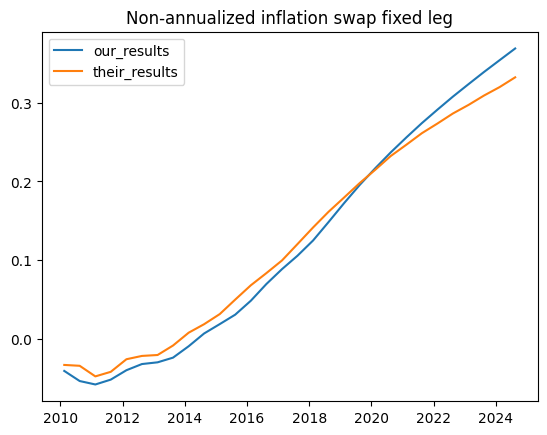

In [43]:
# OBTENEMOS LOS SWI QUE QUEREMOS SALVO LOS DOS PRIMEROS

displacement = 46 / 360

# CPI base: 30 de junio de 2022
cpi0 = assets[cpi_ticker].get_value("20081130").values[0]

# dates = pd.date_range("200901115", "20240215")
# cpdates = dates

# CPI proyectado:
cpiT = curve.get_forward_value("20081230", tenors=np.arange(1, 16, 0.5))
# swap rate anualizado
# print((cpiT/cpi0)**(1/(np.arange(1, 15, 0.5)+displacement))-1)
# print((cpiT/cpi0)-1)
# swap rate mercado

# COMPARISON 1

# Inflation_swap_total = [1.1856, 1.1638, 1.1480, 1.1467, 1.1307, 1.1376, 1.1566, 1.1616, 1.1630, 1.1773, 1.1967, 1.2095, 1.2248, 1.2466, 1.2683, 1.2866, 1.3058, 1.3304, 1.3556, 1.3792, 1.4009, 1.4225, 1.4427, 1.4635, 1.4806, 1.4979, 1.5126, 1.5277, 1.5407, 1.5548, 1.5676, 1.5823]
Inflation_swap = [
    1.1480,
    1.1467,
    1.1307,
    1.1376,
    1.1566,
    1.1616,
    1.1630,
    1.1773,
    1.1967,
    1.2095,
    1.2248,
    1.2466,
    1.2683,
    1.2866,
    1.3058,
    1.3304,
    1.3556,
    1.3792,
    1.4009,
    1.4225,
    1.4427,
    1.4635,
    1.4806,
    1.4979,
    1.5126,
    1.5277,
    1.5407,
    1.5548,
    1.5676,
    1.5823,
]
Inflation_swap_strikes = [x / 1.1875 - 1 for x in Inflation_swap]
# print(Inflation_swap_strikes)
idx = pd.date_range(
    start="2010-Feb-15", periods=30, freq=pd.DateOffset(months=6, day=15)
)
# Create a DataFrame with the values and the DatetimeIndex as the index
table_1 = pd.DataFrame(
    {"our_results": (cpiT / cpi0) - 1, "their_results": Inflation_swap_strikes},
    index=idx,
)
plt.plot(table_1["our_results"], label="our_results")
plt.plot(table_1["their_results"], label="their_results")
plt.legend()
plt.title("Non-annualized inflation swap fixed leg")
plt.show()
# print(table_1)


# COMPARISON 2

# val = ((cpiT/cpi0)*1.1875).tolist()
# #print([val[i] - Inflation_swap[i-1] for i in range(len(val))])
# idx = pd.date_range(start='2010-Feb-15', periods=30, freq=pd.DateOffset(months=6, day=15))
# # Create a DataFrame with the values and the DatetimeIndex as the index
# table_2 = pd.DataFrame({'our_results': val, 'their_results': Inflation_swap}, index=idx)
# plt.plot(table_2['our_results'], label = 'our_results')
# plt.plot(table_2['their_results'], label = 'their_results')
# plt.legend()
# plt.title('Table value')
# plt.show()
# print(table_2)